In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import time
from fit import *
from NEF_RL import *
from NEF_WM import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

## Run locally

In [2]:
def run_and_get_noise_driven(model_type, sid, neurons, seed=0):
    if model_type=='NEF_RL':
        p_nef = pd.read_pickle("data/NEF_RL_jiang_mar11_params.pkl").query("sid==@sid")
        alpha = p_nef['alpha'].unique()[0]
        z = p_nef['z'].unique()[0]
        lambd = p_nef['lambda'].unique()[0]
        beta_nef = p_nef['beta'].unique()[0]
        params_nef = [beta_nef]
        nef_data = run_RL("jiang", sid, alpha=alpha, z=z, lambd=lambd, n_neurons=neurons, n_learning=neurons, n_error=neurons)
    if model_type=='NEF_WM':
        p_nef = pd.read_pickle("data/NEF_WM_jiang_mar11_params.pkl").query("sid==@sid")
        alpha = p_nef['alpha'].unique()[0]
        z = p_nef['z'].unique()[0]
        lambd = p_nef['lambda'].unique()[0]
        beta_nef = p_nef['beta'].unique()[0]
        params_nef = [beta_nef]
        nef_data = run_WM("jiang", sid, alpha=alpha, z=z, lambd=lambd, n_neurons=neurons, n_memory=neurons, n_error=neurons)
    if lambd==0.0:
        math_type = "RL_z"
        p_math = pd.read_pickle(f"data/{math_type}_jiang_mar7_params.pkl").query("sid==@sid")
        alpha_math = p_math['alpha'].unique()[0]
        z_math = p_math['z'].unique()[0]
        beta_math = p_math['beta'].unique()[0]
        params_math = [alpha_math, z_math, beta_math]
    elif lambd==1.0:
        math_type = "DG_z"
        p_math = pd.read_pickle(f"data/{math_type}_jiang_mar7_params.pkl").query("sid==@sid")
        z_math = p_math['z'].unique()[0]
        beta_math = p_math['beta'].unique()[0]
        params_math = [z_math, beta_math]
    human = pd.read_pickle("data/jiang.pkl").query("sid==@sid")
    trials = human.query("sid==@sid")['trial'].unique()
    columns = ['type', 'neurons', 'sid', 'trial', 'stage', 'is_greedy', 'noise_driven']
    dfs = []
    for trial in trials:
        # neighbors = len(human.query("sid==@sid & trial==@trial & stage==1")['who'].unique())
        stages = human.query("sid==@sid & trial==@trial")['stage'].unique()
        for stage in stages:
            expectation_math = get_expectations_jiang(math_type, params_math, sid, trial, stage)
            expectation_nef = get_expectations_jiang(model_type, params_nef, sid, trial, stage)
            prob_math = scipy.special.expit(beta_math*expectation_math)
            prob_nef = scipy.special.expit(beta_nef*expectation_nef)
            action_math = 1 if rng.uniform(0,1) < prob_math else -1
            action_nef = 1 if rng.uniform(0,1) < prob_nef else -1
            action_human = human.query("trial==@trial & stage==@stage")['action'].unique()[0]
            sign_math = 1 if expectation_math > 0 else -1
            sign_nef = 1 if expectation_nef > 0 else -1
            is_greedy = True if action_human==sign_math else False
            noise_driven = True if sign_nef!=sign_math else False
            dfs.append(pd.DataFrame([[model_type, neurons, sid, trial, stage, is_greedy, noise_driven]], columns=columns))
    noise_data = pd.concat(dfs, ignore_index=True)
    return noise_data

In [ ]:
model_types = ['NEF_WM']
sids = pd.read_pickle("data/jiang.pkl")['sid'].unique()
neurons = [50, 100, 200, 400]
dfs = []
for mt in model_types:
    for sid in sids:
        for n in neurons:
            dfs.append(run_and_get_noise_driven(mt, sid=sid, neurons=n))
noise_data = pd.concat(dfs, ignore_index=True)
noise_data.to_pickle("data/jiang_noise_data.pkl")

## Load data

In [3]:
noise_data_wm = pd.read_pickle("data/NEF_WM_mar12two_learning_noise.pkl")
# noise_data_wm = pd.read_pickle("data/NEF_WM_mar12_learning_noise.pkl")
noise_data_rl = pd.read_pickle("data/NEF_RL_mar12_learning_noise.pkl")
noise_data = pd.concat([noise_data_rl, noise_data_wm], ignore_index=True)

## Collect and plot

In [3]:
dfs = []
columns = ['type', 'neurons', 'sid', 'is_greedy', 'noise_driven', "sample size"]
sid = noise_data['sid'].unique()
for model_type in noise_data['type'].unique():
    for sid in noise_data['sid'].unique():
        if sid==213:
            continue
        for neurons in noise_data['neurons'].unique():
            greedy_subdata = noise_data.query("type==@model_type & sid==@sid & neurons==@neurons & is_greedy==True")
            nongreedy_subdata = noise_data.query("type==@model_type & sid==@sid & neurons==@neurons & is_greedy==False")
            greedy_noisy = greedy_subdata.query("noise_driven==True").size
            greedy_choicy = greedy_subdata.query("noise_driven==False").size
            greedy_sample_size = greedy_noisy + greedy_choicy
            greedy_fraction = greedy_noisy / greedy_sample_size
            nongreedy_noisy = nongreedy_subdata.query("noise_driven==True").size
            nongreedy_choicy = nongreedy_subdata.query("noise_driven==False").size
            nongreedy_sample_size = nongreedy_noisy + nongreedy_choicy
            nongreedy_fraction = nongreedy_noisy / nongreedy_sample_size
            dfs.append(pd.DataFrame([[model_type, neurons, sid, True, greedy_fraction, greedy_sample_size]], columns=columns))
            dfs.append(pd.DataFrame([[model_type, neurons, sid, False, nongreedy_fraction, nongreedy_sample_size]], columns=columns))
noise_data_fraction = pd.concat(dfs, ignore_index=True)

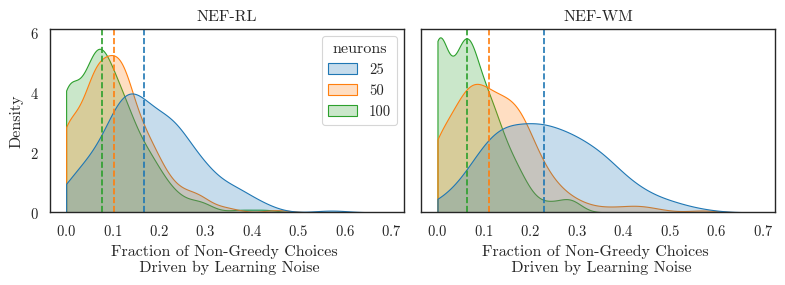

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), sharey=True, sharex=True)
sns.kdeplot(noise_data_fraction.query("type=='NEF_RL' & is_greedy==False"), x='noise_driven', hue='neurons',
            palette=palette[:3], common_norm=False, fill=True, clip=[0,1], ax=axes[0])
sns.kdeplot(noise_data_fraction.query("type=='NEF_WM' & is_greedy==False"), x='noise_driven', hue='neurons',
            palette=palette[:3], common_norm=False, fill=True, clip=[0,1], ax=axes[1])
for n, neurons in enumerate(noise_data_fraction['neurons'].unique()):
    median = noise_data_fraction.query("type=='NEF_RL' & is_greedy==False & neurons==@neurons")['noise_driven'].median()
    axes[0].axvline(median, color=palette[n], ls="--")
    median = noise_data_fraction.query("type=='NEF_WM' & is_greedy==False & neurons==@neurons")['noise_driven'].median()
    axes[1].axvline(median, color=palette[n], ls="--")
axes[0].set(xlabel="Fraction of Non-Greedy Choices \n Driven by Learning Noise", title="NEF-RL")
axes[1].set(xlabel="Fraction of Non-Greedy Choices \n Driven by Learning Noise", title="NEF-WM")
axes[1].get_legend().remove()
plt.tight_layout()
fig.savefig("plots/learning_noise_vs_neurons_jiang.jpg", dpi=600)